In [102]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [30]:
train_raw = pd.read_csv('data_sets/train.csv')

In [31]:
def fill_nan(column):
    avg = column.mean()
    return column.fillna(avg)
def preprocess(data):
    gender_map = {'male':1,'female':0}
    embarked_map = {'C':0,'Q':1,'S':2}
    data['Sex'] = data['Sex'].map(gender_map)
    data['Embarked'] = data['Embarked'].map(embarked_map)
    data = data.apply(lambda x: x.fillna(x.mean()),axis=1)
    return data

In [32]:
ignore = ['Name','Ticket','Cabin','PassengerId']
train = train_raw.drop(ignore,axis=1)
train_x = preprocess(train)
train_x = train_x.drop(['Survived'],axis=1)
train_y = train['Survived'].values
print train_x.shape
print train_y.shape

(891, 7)
(891,)


In [33]:
print train_x.columns
print train_x

Index([u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare', u'Embarked'], dtype='object')
     Pclass  Sex        Age  SibSp  Parch      Fare  Embarked
0         3    1  22.000000      1      0    7.2500         2
1         1    0  38.000000      1      0   71.2833         0
2         3    0  26.000000      0      0    7.9250         2
3         1    0  35.000000      1      0   53.1000         2
4         3    1  35.000000      0      0    8.0500         2
5         3    1   1.922614      0      0    8.4583         1
6         1    1  54.000000      0      0   51.8625         2
7         3    1   2.000000      3      1   21.0750         2
8         3    0  27.000000      0      2   11.1333         2
9         2    0  14.000000      1      0   30.0708         0
10        3    0   4.000000      1      1   16.7000         2
11        1    0  58.000000      0      0   26.5500         2
12        3    1  20.000000      0      0    8.0500         2
13        3    1  39.000000      1     

In [44]:
clf = RandomForestClassifier(n_estimators=100,max_depth=len(train_x.columns))

In [45]:
clf.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Naive guess on test data without and cross validation

In [87]:
test_raw = pd.read_csv('data_sets/test.csv')
test = test_raw.drop(ignore,axis=1)
test_x = preprocess(test)

In [88]:
predictions = clf.predict(test_x)
print predictions

[0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 1]


In [48]:
np.savetxt('titanic_RF_naive.csv',
           np.c_[test_raw['PassengerId'],predictions],
           delimiter=',',
           header='PassengerId,Survived',
           fmt='%d',
           comments='')

# Lets try a less Naive Guess

In [56]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train_x, train_y, test_size=100, random_state=0)

In [76]:
def cross_validation(train_x,train_y,p_range,k=50,parameter='n_estimators',**kwargs):
    X_train, X_valid, Y_train, Y_valid = train_test_split(train_x, train_y, test_size=0.15, random_state=0)
    errors = []
    for p in p_range:
        kfold = KFold(len(X_train), n_folds=k,shuffle=True,random_state=0)
        error = 0
        params = dict({parameter:p},**kwargs)
        for train_index, val_index in kfold:
            x_train = X_train.iloc[train_index]
            y_train = Y_train[train_index]
            x_val = X_train.iloc[val_index]
            y_val = Y_train[val_index]
            clf = RandomForestClassifier(**params)
            clf.fit(x_train,y_train)
            predictions = clf.predict(x_val)
            err = np.sum((predictions != y_val),dtype=float)/len(y_val)
            error += err/k
        print p,':',error
        errors.append(error)
    best = p_range[np.argmin(errors)]
    return best,errors

In [77]:
estim_range = np.arange(0,310,10)
estim_range[0] = 1
args = {'max_depth':len(train_x.columns)}
best_estimator,estim_errors = cross_validation(train_x,train_y,estim_range,k=50,parameter='n_estimators',**args)

1 : 0.219833333333
10 : 0.1795
20 : 0.180833333333
30 : 0.176916666667
40 : 0.171916666667
50 : 0.174083333333
60 : 0.177083333333
70 : 0.175583333333
80 : 0.1705
90 : 0.177
100 : 0.1705
110 : 0.169083333333
120 : 0.174333333333
130 : 0.170333333333
140 : 0.169166666667
150 : 0.1705
160 : 0.1665
170 : 0.17025
180 : 0.174333333333
190 : 0.165083333333
200 : 0.1705
210 : 0.1705
220 : 0.169166666667
230 : 0.1705
240 : 0.174416666667
250 : 0.16775
260 : 0.174166666667
270 : 0.180916666667
280 : 0.172916666667
290 : 0.175666666667
300 : 0.171583333333


In [78]:
depth_range = np.arange(1,2*len(train_x.columns))
args = {'n_estimators':best_estimator}
best_depth,depth_errors = cross_validation(train_x,train_y,depth_range,k=50,parameter='max_depth',**args)

1 : 0.240416666667
2 : 0.219333333333
3 : 0.198083333333
4 : 0.185916666667
5 : 0.18075
6 : 0.17575
7 : 0.166333333333
8 : 0.170583333333
9 : 0.171916666667
10 : 0.1745
11 : 0.178583333333
12 : 0.179833333333
13 : 0.183916666667


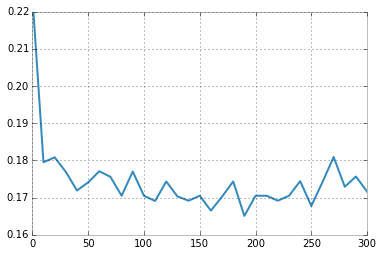

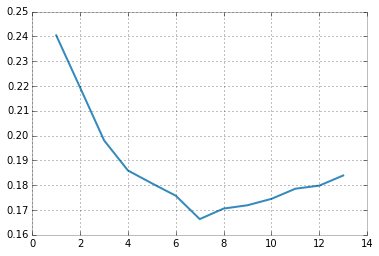

In [81]:
estim = plt.plot(estim_range,estim_errors,label='n trees')
plt.show()
depth = plt.plot(depth_range,depth_errors,label='depth')
plt.show()

In [82]:
best_forest = RandomForestClassifier(n_estimators=best_estimator,max_depth=best_depth)
best_forest.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=190, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [84]:
predictions = best_forest.predict(X_valid)
error = np.sum(predictions!=Y_valid,dtype=float)/len(Y_valid)
print error

0.19


In [85]:
best_forest.fit(train_x,train_y)
test_predictions = best_forest.predict(test_x)

In [92]:
np.savetxt('titanic_RF_lessnaive.csv',
           np.c_[test_raw['PassengerId'],test_predictions],
           delimiter=',',
           header='PassengerId,Survived',
           fmt='%d',
           comments='')

# Slight improvement over logistic regression

# More cross validation may help

In [104]:
feature_range = range(1,len(train_x.columns)+1)+['auto','log2','sqrt']
args = {'max_depth':len(train_x.columns),'n_estimators':best_estimator}
best_feature,feature_errors = cross_validation(train_x,train_y,feature_range,k=50,parameter='max_features',**args)

1 : 0.167916666667
2 : 0.163833333333
3 : 0.171416666667
4 : 0.168833333333
5 : 0.17275
6 : 0.1715
7 : 0.174166666667
auto : 0.169083333333
log2 : 0.178166666667
sqrt : 0.17425


In [105]:
best_feature

2

In [106]:
best_forest = RandomForestClassifier(n_estimators=best_estimator,max_depth=best_depth,max_features=best_feature)
best_forest.fit(X_train,Y_train)
predictions = best_forest.predict(X_valid)
error = np.sum(predictions!=Y_valid,dtype=float)/len(Y_valid)
print error

0.18


In [107]:
best_forest.fit(train_x,train_y)
test_predictions = best_forest.predict(test_x)

In [108]:
np.savetxt('titanic_RF_xv3.csv',
           np.c_[test_raw['PassengerId'],test_predictions],
           delimiter=',',
           header='PassengerId,Survived',
           fmt='%d',
           comments='')

In [115]:
penalty_functions = ['gini','entropy']
args = {'max_depth':best_depth,'n_estimators':best_estimator,'max_features':best_feature}
best_function,function_errors = cross_validation(train_x,train_y,penalty_functions,k=50,parameter='criterion',**args)

gini : 0.16625
entropy : 0.170333333333


#Begin Feature Engineering

### Trying single features as predictors

In [150]:
features = X_train.columns

In [154]:
single_feature_error = []
for feat in features:
    single_forest = RandomForestClassifier(n_estimators=best_estimator,criterion=best_function)
    single_forest.fit(X_train[[feat]],Y_train)
    predicts = single_forest.predict(X_valid[[feat]])
    err = np.sum(predicts!=Y_valid,dtype=float)/len(Y_valid)
    single_feature_error.append(err)
    print feat,':',err
best_1 = features[np.argmin(single_feature_error)]
print 'Best Single Feature:',best_1

Pclass : 0.29
Sex : 0.21
Age : 0.45
SibSp : 0.39
Parch : 0.4
Fare : 0.33
Embarked : 0.37
Best Single Feature: Sex


In [159]:
features_2 = features.drop(best_1)

In [160]:
double_feature_error = []
for feat in features_2:
    if feat == best_1: continue
    double_forest = RandomForestClassifier(n_estimators=best_estimator,criterion=best_function)
    double_forest.fit(X_train[[best_1,feat]],Y_train)
    predicts = double_forest.predict(X_valid[[best_1,feat]])
    err = np.sum(predicts!=Y_valid,dtype=float)/len(Y_valid)
    double_feature_error.append(err)
    print feat,':',err
best_2 = features_2[np.argmin(double_feature_error)]
print 'Best Double Feature:',[best_1,best_2]

Pclass : 0.21
Age : 0.26
SibSp : 0.19
Parch : 0.2
Fare : 0.2
Embarked : 0.21
Best Double Feature: ['Sex', 'SibSp']


In [161]:
features_3 = features.drop([best_1,best_2])

In [162]:
triple_feature_error = []
for feat in features_3:
    if feat in [best_1,best_2]: continue
    triple_forest = RandomForestClassifier(n_estimators=best_estimator,criterion=best_function)
    triple_forest.fit(X_train[[best_1,best_2,feat]],Y_train)
    predicts = triple_forest.predict(X_valid[[best_1,best_2,feat]])
    err = np.sum(predicts!=Y_valid,dtype=float)/len(Y_valid)
    triple_feature_error.append(err)
    print feat,':',err
best_3 = features_3[np.argmin(triple_feature_error)]
print 'Best Triple Feature:',[best_1,best_2,best_3]

Pclass : 0.18
Age : 0.25
Parch : 0.2
Fare : 0.24
Embarked : 0.19
Best Triple Feature: ['Sex', 'SibSp', 'Pclass']


In [163]:
three_forest = RandomForestClassifier(n_estimators=best_estimator,criterion=best_function)
three_forest.fit(train_x[[best_1,best_2,best_3]],train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=190, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [164]:
test_predictions_3 = three_forest.predict(test_x[[best_1,best_2,best_3]])
np.savetxt('titanic_RF_three.csv',
           np.c_[test_raw['PassengerId'],test_predictions_3],
           delimiter=',',
           header='PassengerId,Survived',
           fmt='%d',
           comments='')

In [167]:
print np.sum(test_predictions_3 != test_predictions)

46
